In [107]:
# Step 1

class Multinomial_NB: 
    
#     def _init_(self, alpha=1.0):
#         self.alpha = alpha

#     def fit(self, X, Y):
#         m, n = X.shape
#         self.c = np.unique(Y)
#         print(self.c)
#         countClass = len(self.c)
        
#         # Class Prior(pi), Feature Likelihood(theta)
#         # Initalize array for prior and matrix for likelihood
#         self.prior = np.zeros(countClass)
#         self.likelihood = np.zeros((countClass, n))
        
#         # Find prior and likelihood
#         for i, c in enumerate(self.c):
#             numberSample = X[np.where(Y == c)]
#             print(numberSample)
#             self.prior[i] = numberSample.shape[0] / m
#             print(numberSample.shape[0])
#             print(self.prior[i])
#             self.likelihood[i,:] = ((numberSample.sum(axis=0))+self.alpha) / (np.sum(numberSample.sum(axis=0)+self.alpha))
        
#     def predict(self, X):
#         return [self.predict_log_proba(xPredict) for xPredict in X]
    
#     def predict_log_proba(self, X):
#         posterior = []
        
#         for i in range(countClass):
#             log_prior = np.log(self.prior[i])
#             log_likelihood = np.log(self.likelihood[i,:])*X
#             log_posterior = np.sum(log_likelihood) + log_prior
#             posterior.append(log_posterior)
        
#         return self.c[np.argmax(posterior)]
    
#     def predict_proba(self, X):
#         return pow(2, self.predict_log_proba(X))

    def _init_(self, alpha=1.0):
        # Initialization function to instantiate the class.
        self.alpha = alpha
        self.priors = None
        self.cond_prob = None
        self.labels = None
        
    def fit(self, X, Y):
        """
        Arguments:
            X : ndarray
                A numpy array with rows representing data samples and columns
            representing numerical features.
            Y : ndarray
                A 1D numpy array with labels corresponding to each row of the feature
            matrix X.
        Returns:
            No return value necessary.
        """
        n, p = X.shape
        # Compute prior probability.
        labels, labels_count = np.unique(Y, return_counts=True)
        k = len(labels)
        prior_lst = (labels_count+self.alpha)/(n+k*self.alpha)
        self.priors = {labels[i]: prior_lst[i] for i in range(k)}
        
        # Compute conditional prob.
        self.cond_prob = {j:{} for j in range(p)}
        for j in range(p):
            samples, _ = np.unique(X[:, j], return_counts=True)
            Sj = len(samples)
            for k in range(len(labels)):
                ck = labels[k]
                ck_count = labels_count[k]
                samples, samples_count = np.unique(X[np.where(Y==ck), j], return_counts=True)
                cond_prob_arr = (samples_count+self.alpha)/(ck_count+Sj*self.alpha)
                cond_prob_dict = {samples[i]: cond_prob_arr[i] for i in range(len(samples))}
                # If the sample value does not exist.
                cond_prob_dict['NotExist'] = self.alpha/(ck_count+Sj*self.alpha)
                self.cond_prob[j][ck] = cond_prob_dict
                
    def predict(self, X):
        """
        Arguments:
            X : ndarray
                A numpy array containing samples to be used for prediction. Its rows
            represent data samples and columns represent numerical features.
        Returns:
            1D array of predictions for each row in X.
            The 1D array should be designed as a column vector.
        """
        pred = []
        n, p = X.shape
        for i in range(n):
            # Save the maximum posterior and responding label.
            max_post = 0
            label = None
            for ck in self.priors.keys():
                prior = self.priors[ck]
                cond = 1
                for j in range(p):
                    val = self.cond_prob[j][ck].get(X[i, j])
                    if val:
                        cond *= val
                    else:
                        cond *= self.cond_prob[j][ck]['NotExist']
                cur_post = prior * cond
                if cur_post > max_post:
                    max_post = cur_post
                    label = ck
            pred.append(label)
        return pred
        
    def predict_log_proba(self, X):
        """
        Arguments:
            X : ndarray
                A numpy array containing samples to be used for prediction. Its rows
            represent data samples and columns represent numerical features.
        Returns:
            A numpy array that contains log-probability of the samples (unnormalized
            log posteriors) for each class in the model. The number rows are equal to
            the rows in X and number of columns are equal to the number of classes.
        """
        n, p = X.shape
        posteriors = np.zeros((n, len(self.priors.keys())))
        for i in range(n):
            for k in range(len(self.priors.keys())):
                ck = list(self.priors.keys())[k]
                prior = self.priors[ck]
                cond = 1
                for j in range(p):
                    val = self.cond_prob[j][ck].get(X[i, j])
                    if val:
                        cond *= val
                    else:
                        cond *= self.cond_prob[j][ck]['NotExist']
                posteriors[i][k] = prior * cond
        return np.log2(posteriors)
    
    def predict_proba(self, X):
        """
        This method returns probability estimates for the test matrix X.
        Arguments:
            X : ndarray
                A numpy array containing samples to be used for prediction. Its
            rows represent data samples and columns represent numerical
            features.
        Returns:
        A numpy array that contains probability of the samples
        (unnormalized posterior) for each class in the model. The number
        rows are equal to the rows in X and number of columns are equal
        to the number of classes.
        """
        return pow(2, self.predict_log_proba(X))

In [8]:
# Step 2

import pandas as pd

df = pd.read_csv('SMSSpamCollection', sep='\t', names=['label','sms_message'])
df.head()

,label,sms_message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
# Step 3

df['length'] = df['sms_message'].map(lambda text: len(text))

df.groupby('label').length.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,4825.0,71.482487,58.440652,2.0,33.0,52.0,93.0,910.0
spam,747.0,138.670683,28.873603,13.0,133.0,149.0,157.0,223.0


In [10]:
# Step 3

df['label'] = df.label.map({'ham':0, 'spam':1})
df.head()

,label,sms_message,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


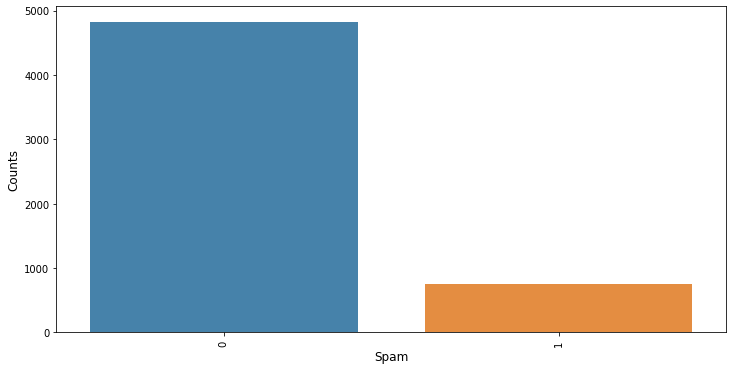

In [45]:
# Step 4
# 0 ham, 1 spam

import seaborn as sns
import matplotlib.pyplot as plt
 
label_counts = df.label.value_counts()
plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)

plt.xticks(rotation = 'vertical')
plt.xlabel('Spam', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

In [ ]:
#Step 5

In [17]:
%%time
# import ssl
# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

import nltk
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

df['text_lemmatized'] = df['sms_message'].map(lambda text: ' '.join(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text.lower())))

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/uekiyeap/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/uekiyeap/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


CPU times: user 4.76 s, sys: 244 ms, total: 5.01 s
Wall time: 7.61 s


In [6]:
print(df['sms_message'][2])
print("\nLemmatized Email:\n")
print(df['text_lemmatized'][2])

Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Lemmatized Email:

free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005. text fa to 87121 to receive entry question ( std txt rate ) t & c 's apply 08452810075over18 's


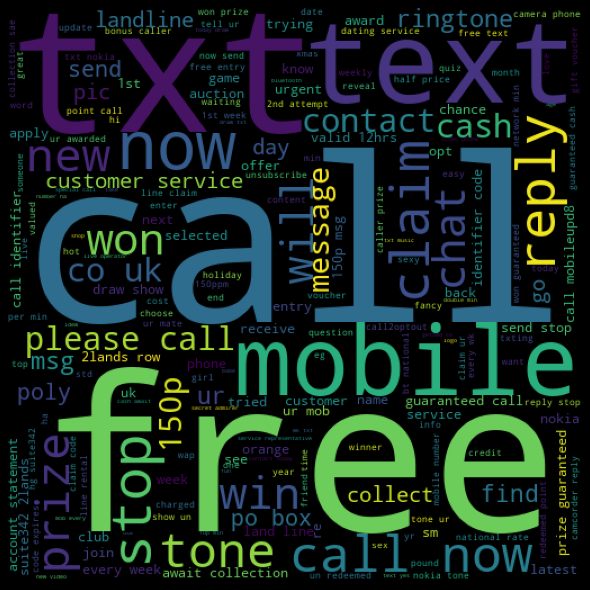

In [9]:
#Step 6
from wordcloud import WordCloud

#for spam messages
spam_words = ''.join(list(df[df['label']==1]['text_lemmatized']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

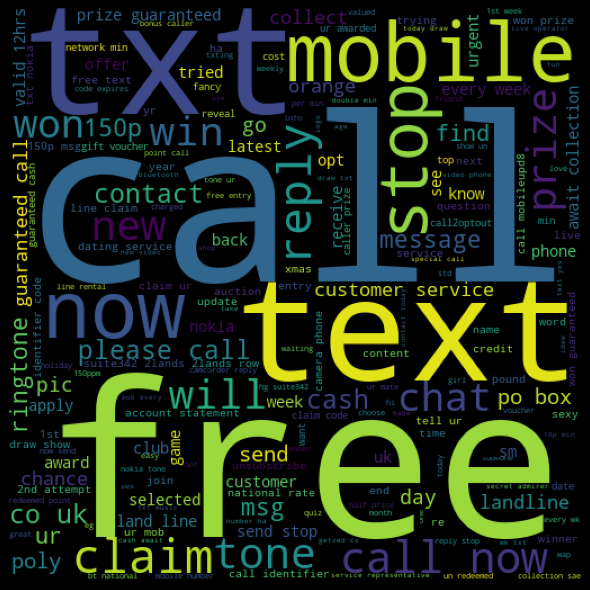

In [10]:
#Step 6

from wordcloud import WordCloud

#for spam messages
spam_words = ''.join(list(df[df['label']==1]['text_lemmatized']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [32]:
# Step 7
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

documents = df['text_lemmatized']

count_vect = CountVectorizer(lowercase=True, stop_words='english')
document_counts = count_vect.fit_transform(documents)

documents = np.array(documents)

print("\nFeature Names:")
print(count_vect.get_feature_names())


print("\nVocabulary: ", count_vect.vocabulary_)


print("\nCount Vector Matrix (Dense Matrix):")
print(document_counts.toarray())

print(document_counts.shape)


Feature Names:
['00', '000', '000pes', '008704050406', '0089', '0121', '01223585236', '01223585334', '0125698789', '02', '0207', '02072069400', '02073162414', '02085076972', '021', '03', '04', '0430', '05', '050703', '0578', '06', '07', '07008009200', '07046744435', '07090201529', '07090298926', '07099833605', '07123456789', '0721072', '07732584351', '07734396839', '07742676969', '07753741225', '0776xxxxxxx', '07781482378', '07786200117', '077xxx', '078', '07801543489', '07808', '07808247860', '07808726822', '07815296484', '07821230901', '078498', '07880867867', '0789xxxxxxx', '07946746291', '0796xxxxxx', '07973788240', '07xxxxxxxxx', '08', '0800', '08000407165', '08000776320', '08000839402', '08000930705', '08000938767', '08001950382', '08002888812', '08002986030', '08002986906', '08002988890', '08006344447', '0808', '08081263000', '08081560665', '0825', '083', '0844', '08448350055', '08448714184', '0845', '08450542832', '08452810071', '08452810073', '08452810075over18', '0870', '087

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(5572, 7935)


In [38]:
# Step 8

X = df['text_lemmatized']
y = df['label']

print(X.shape)
print(y.shape)

(5572,)
(5572,)
it a part of checking iq


In [33]:
# Step 9
df = df.sample(frac=1) 
df.head()

,label,sms_message,length,text_lemmatized
62,0,Its a part of checking IQ,25,it a part of checking iq
501,0,"Fighting with the world is easy, u either win ...",149,"fighting with the world is easy , u either win..."
2722,0,I'm working technical support :)voice process.,46,i 'm working technical support : ) voice proce...
2013,0,Beautiful Truth against Gravity.. Read careful...,158,beautiful truth against gravity .. read carefu...
4418,0,says that he's quitting at least5times a day ...,200,say that he 's quitting at least5times a day s...


In [68]:
#Step 10

# Splitting the data into Train Set and Test Set
def partition(X,y,t):
    x_train = np.array(X[int((len(X)+1)*t):])
    x_test = np.array(X[:int((len(X)+1)*t)])
    y_train = np.array(y[int((len(y)+1)*t):])
    y_test = np.array(y[:int((len(y)+1)*t)]) 
    return x_train, x_test, y_train, y_test

#separate the target vector and features
def separateTargetVector(dataSet):
    y = dataSet['label'] #target vector
    X = dataSet.drop(columns='label') #features matrix
    t = 0.2
    return X,y,t

#a function to split data into partition
#according to the number of folds
def partitionSplit(df, folds):
    s_partition = []
    dfCopy = df
    #set the size for each partiton
    eachPartition = int(df.shape[0] / folds)
    for i in range(folds):
        partition = []
        #going through each partition
        for j in range(eachPartition):
            if(len(partition) < eachPartition):
                value = dfCopy.index[0]
                partition.append(value.tolist())
                dfCopy = dfCopy.drop(value)
        s_partition.append((np.asarray(partition)).tolist())
  
    return s_partition


In [111]:
# Functions for Part D

# Returns the Accuracy
def accuracy(predicted, actual):
    accuracy = sum(np.array(predicted) == np.array(actual)) / float(len(actual))
    return accuracy

# Calculates Precision Values when inputs are TP and FP 
# that are based upon the probability and threshold
def precisions(tp, fp):
    score = []
    for i in range(len(tp)):
        precision = tp[i] / (tp[i] + fp[i])
        i += 1
        score.append(precision)
    return score

# Calculates Recall Values when inputs are TP and FN 
# that are based upon the probability and threshold
def recalls(tp, fn):
    score = []
    for i in range(len(tp)):
        recall = tp[i] / (tp[i] + fn[i])
        i += 1
        score.append(recall)
    return score


# Calculates Precision Score when input arguments are Test Labels and the 
# predicted labels
def precisionScore(yTest, yPredict):
    tp = sum((np.array(yTest) == 1) & (np.array(yPredict) == 1))
    fp = sum((np.array(yTest) == 0) & (np.array(yPredict) == 1))
    score = tp/(tp+fp)
    return score

# Calculates Recall Score when input arguments are Test Labels and the 
# predicted labels
def recallScore(yTest, yPredict):
    tp = sum((np.array(yTest) == 1) & (np.array(yPredict) == 1))
    fn = sum((np.array(yTest) == 1) & (np.array(yPredict) == 0))
    score = tp/(tp+fn)
    return score

# Calculates F1 Score when input arguments are Test Labels and the 
# predicted labels
def f1_score(yTest, yPredict):
    tp = sum((np.array(yTest) == 1) & (np.array(yPredict) == 1))
    fn = sum((np.array(yTest) == 1) & (np.array(yPredict) == 0))
    fp = sum((np.array(yTest) == 0) & (np.array(yPredict) == 1))
    score = tp / (tp + ((fn + fp) / 2))
    return score

# Generates the Confusion Matrix
def confusionMatrix(actual, predicted):
    confusionLists = np.unique(actual)
    matrixSize = len(confusionLists)
    matrix = np.zeros((matrixSize, matrixSize))
    for i in range (matrixSize):
        for j in range (matrixSize):
            matrix[i, j] = np.sum((actual == confusionLists[i]) & (predicted == confusionLists[j]))
    return matrix

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

# Generates the ROC Curve

def roc_curve(yTest, probability, label=None):
    fprList = []
    tprList = []
    
    thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    fpValues = []
    fnValues = []
    tpValues = []
    tnValues = []

    # Getting a new array of predictions based on the thresholds and the
    # array of probabilities of "1: Good Wine" in KNN
    for j in range(len(thresholds)):
        newValues = []
        for i in range(len(probability)):
            if (probability[i] < thresholds[j]):
                newValues.append(0)
            else:
                newValues.append(1)
        for k in range(len(newValues)):
        
            tp = sum((np.array(yTest) == 1) & (np.array(newValues) == 1))
            fn = sum((np.array(yTest) == 1) & (np.array(newValues) == 0))
            fp = sum((np.array(yTest) == 0) & (np.array(newValues) == 1))
            tn = sum((np.array(yTest) == 0) & (np.array(newValues) == 0))

        tpValues.append(tp)
        fnValues.append(fn)
        fpValues.append(fp)
        tnValues.append(tn)

    for i in range(len(fpValues)):
        fpr = fpValues[i]/(fpValues[i]+tnValues[i]) #False Positive Rate
        tpr = tpValues[i]/(tpValues[i]+fnValues[i]) #True Positive Rate
        
        #put point by point into list
        fprList.append(fpr)
        tprList.append(tpr)
        
    print(fprList)
    print(tprList)
    
    #Plotting
    fig = plt.figure(figsize=(10, 6))
    plt.plot(fprList, tprList, color='darkorange', linewidth=8, label=label) 
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.axis([0, 1, 0, 1])
    plt.title('ROC Curve (Train Data)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()


# Generates the AUC values
def AUC(yTest, probability):
    fprList = []
    tprList = []
    
    thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    fpValues = []
    fnValues = []
    tpValues = []
    tnValues = []

    # Getting a new array of predictions based on the thresholds and the
    # array of probabilities of "1: Good Wine" in KNN
    for j in range(len(thresholds)):
        newValues = []
        for i in range(len(probability)):
            if (probability[i] < thresholds[j]):
                newValues.append(0)
            else:
                newValues.append(1)
        for k in range(len(newValues)):
            tp = sum((np.array(yTest) == 1) & (np.array(newValues) == 1))
            fn = sum((np.array(yTest) == 1) & (np.array(newValues) == 0))
            fp = sum((np.array(yTest) == 0) & (np.array(newValues) == 1))
            tn = sum((np.array(yTest) == 0) & (np.array(newValues) == 0))

        tpValues.append(tp)
        fnValues.append(fn)
        fpValues.append(fp)
        tnValues.append(tn)

    for i in range(len(fpValues)):     
        fpr = fpValues[i]/(fpValues[i]+tnValues[i])
        tpr = tpValues[i]/(tpValues[i]+fnValues[i])
        #put point by point into list
        fprList.append(fpr)
        tprList.append(tpr)

    fprList = np.flip(fprList)
    tprList = np.flip(tprList)
    
    auc = np.trapz(tprList, fprList)
    
    return auc

In [109]:
#Step 11

def sFold(folds, data, labels, model, error_function, dictionary): 
    avgF1Score = [] 
    splitX = partitionSplit(data, folds)

    #loop to choose a partition as validation set
    for i, partition in enumerate(splitX):
        trainSet = list(splitX)
        del(trainSet[i])       #dropping the validation set
        trainSet = sum(trainSet, [])

        testSet = []           #getting the validation set 
        for row in partition:
            testSet.append(row)  #put data in validation set into a new list 
            
        #splitting the data into train and test set
        xTrainValues = []
        yTrainValues = []        
        for trainIndex in trainSet:
            xTrainValues.append(data.loc[trainIndex])
            yTrainValues.append(labels.loc[trainIndex])

        #splitting the validation set data into train and test set
        xTestValues = []
        yTestValues = []
        for testIndex in testSet:
            xTestValues.append(data.loc[testIndex])
            yTestValues.append(labels.loc[testIndex])
    
        #preform prediction using KNN
        if model == 'Multinomial_NB':
            modelClassifier = Multinomial_NB()
            modelClassifier._init_(alpha=dictionary.get('alpha'))
            modelClassifier.fit(np.array(xTrainValues), np.array(yTrainValues))
            yPredict = modelClassifier.predict(np.array(xTestValues))
            accuracy_value = accuracy(yPredict, np.array(yTestValues))
            print('Accuracy: %.3f' %accuracy_value)
            
            #calculating the error using f1 score
            if error_function == 'f1':
                error = f1_score(np.array(yTestValues), yPredict)
                avgF1Score.append(error)
            
            print('F1 Score: %.3f' %error)
            print('\n')
      
    #get the average f1 score for the current k
    avgFinalF1Score = sum(avgF1Score) / len(avgF1Score) 
    print(avgFinalF1Score) 
    print('\n')

    return {'expected labels': yTestValues, 'predicted labels': yPredict, 'errors': [error]}

In [112]:
#get the X data(features without target) and y data(target column)
X,y,t = separateTargetVector(df)

#function to pass the hyperparameter into s-fold validation
def dictionary(alpha):
    modelArgs = dict()
    #form the dictionary
    for eachAlpha in alpha:
        modelArgs = {'alpha': eachAlpha}
        #use of s-folds
        out = sFold(5, X, y, 'Multinomial_NB', 'f1', modelArgs)

alpha = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0]

dictionary(alpha)

Accuracy: 0.707
F1 Score: 0.492


Accuracy: 0.680
F1 Score: 0.405


Accuracy: 0.680
F1 Score: 0.449


Accuracy: 0.705
F1 Score: 0.472


Accuracy: 0.678
F1 Score: 0.431


0.44975648798762097


Accuracy: 0.707
F1 Score: 0.492


Accuracy: 0.680
F1 Score: 0.405


Accuracy: 0.680
F1 Score: 0.449


Accuracy: 0.705
F1 Score: 0.472


Accuracy: 0.678
F1 Score: 0.431


0.44975648798762097


Accuracy: 0.707
F1 Score: 0.492


Accuracy: 0.680
F1 Score: 0.405


Accuracy: 0.680
F1 Score: 0.449


Accuracy: 0.705
F1 Score: 0.472


Accuracy: 0.691
F1 Score: 0.442


0.451855814968089


Accuracy: 0.768
F1 Score: 0.545


Accuracy: 0.756
F1 Score: 0.458


Accuracy: 0.769
F1 Score: 0.525


Accuracy: 0.776
F1 Score: 0.539


Accuracy: 0.741
F1 Score: 0.481


0.5095661971413905


Accuracy: 0.846
F1 Score: 0.623


Accuracy: 0.823
F1 Score: 0.521


Accuracy: 0.843
F1 Score: 0.598


Accuracy: 0.849
F1 Score: 0.616


Accuracy: 0.845
F1 Score: 0.581


0.5876902257081318


Accuracy: 0.877
F1 Score: 0.655


Accuracy: 

In [115]:
#Step 12

X,y,t = separateTargetVector(df)
xTrain, xTest, yTrain, yTest = partition(X, y, t)
modelClassifier = Multinomial_NB()
modelClassifier._init_(alpha=1.5)
modelClassifier.fit(np.array(xTrain), np.array(yTrain))
yPredict = modelClassifier.predict(np.array(xTest))
yPredict = np.array(yPredict)

# # Plot the ROC Curve
# print("ROC_curve:")
# roc_curve(yTest, probability)
# print("\n")

# # Get the AUC Value
# print("AUC_curve:")
# auc = AUC(yTest, probability)
# print("AUC: %f" %auc)
# print("\n")

In [116]:
# Step 13

print('Precision:', precisionScore(yTest, yPredict))
print('Recall:', recallScore(yTest, yPredict))
print('F1 score:', f1_score(yTest, yPredict))
print('Accuracy:', accurary(yTest, yPredict))
print('Confusion Matrix:', confusionMatrix(yTest, yPredict))
print("\n")

Precision: 0.592391304347826
Recall: 0.6687116564417178
F1 score: 0.6282420749279539
Accuracy: 0.8842010771992819
Confusion Matrix: [[876.  75.]
 [ 54. 109.]]


